# Baseline models on resampled data

In [7]:
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import boto3

from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


import scikitplot as skplt

import xgboost as xgb

from utils.evaluation import evaluate_model
from utils.report import report_by_sections
from utils.plots import plot_case

In [8]:
train_data = pd.read_csv("data/train_data.csv", parse_dates=["block_time"])

In [9]:
train_data.shape

(651040, 117)

In [10]:
features = [f for f in train_data.columns if f.endswith("_log_to_median_ratio")]

In [11]:
len(features)

53

In [12]:
import os
os.getcwd()

'c:\\Users\\Anton\\Desktop\\s2\\attack-detection-v1'

In [13]:
#cases = pd.read_csv("Validated_V0_Desriptions.csv").rename(
#    {"File Names": "file_name", "Exploit Types": "exploit_type"}, axis=1
#)
cases = pd.read_csv("V3_.csv").rename(
    {"File Names": "file_name", "Exploit Types": "exploit_type"}, axis=1
)
cases["file_name"] += ".csv"
cases["file_name"] = 'V3/' + cases['file_name'].astype(str)#cases["file_name"] = 'V3/' + cases['file_name'].astype(str)
cases = cases.loc[:, ["file_name", "exploit_type", "Minimum Date", "train/test splits"]]#
#cases = cases.loc[:, ["file_name", "exploit_type", "Minimum Time", "train/test splits", "Attack Link"]]

In [14]:
cases["exploit_type"].value_counts()

Access Control        75
Rug pull              33
Flash Loan Attack     26
Phishing              23
Price Manupilation     7
Re-Entrancy            3
Name: exploit_type, dtype: int64

In [15]:
phishing_files = list(cases.loc[cases["exploit_type"] == "Phishing", "file_name"])

Mark transactions that we would not like the model to alert on

In [16]:
def should_not_alert(df):
    return (df["label"] == 1) & (
        (df["amount_usd_tx_sum"] < 1)  # amount under $1
        | (df["file_name"].isin(phishing_files))  # phishing
    )

In [17]:
train_data.shape

(651040, 117)

In [18]:
train_data["no_alert"] = should_not_alert(train_data)

In [19]:
model_train_data = train_data.loc[
    ~train_data["no_alert"],
    ["file_name", "transaction_id", "block_time"] + features + ["label"],
].fillna(0)

In [20]:
model_train_data.shape

(650745, 57)

In [21]:
validation_data = pd.read_csv("data/validation_data.csv", parse_dates=["block_time"])

In [24]:
fake_data = pd.read_csv("data/fake_data.csv", parse_dates=["block_time"])

In [25]:
validation_data["no_alert"] = should_not_alert(validation_data)

## 1 Create train sample with balanced tx count between cases

In [26]:
tx_count = train_data.groupby("file_name")["transaction_id"].nunique()

Exclude cases with very few transactions

In [27]:
tx_count[tx_count < 20]

file_name
V3/Audius.csv                   5
V3/CompounderFinance004.csv    14
V3/CompounderFinance005.csv     3
V3/Lympo002.csv                 3
V3/Taylor001.csv                7
V3/dxHub001.csv                18
Name: transaction_id, dtype: int64

In [28]:
files_to_exclude = list(tx_count[tx_count < 20].index)
files_to_exclude

['V3/Audius.csv',
 'V3/CompounderFinance004.csv',
 'V3/CompounderFinance005.csv',
 'V3/Lympo002.csv',
 'V3/Taylor001.csv',
 'V3/dxHub001.csv']

In [29]:
files_to_exclude += phishing_files

In [30]:
file_names = train_data["file_name"].drop_duplicates()

In [31]:
target_fer_file = 50
ref_per_file = 300
samples = []
np.random.seed(1234)
for f in file_names:
    if f not in files_to_exclude:
        df = model_train_data.loc[model_train_data["file_name"] == f, :]
        samples.append(
            df.loc[df["label"] == 1, :].sample(target_fer_file, replace=True)
        )
        samples.append(df.loc[df["label"] == 0, :].sample(ref_per_file, replace=True))
train_sample = pd.concat(samples).reset_index(drop=True)

In [32]:
train_sample.shape

(32200, 57)

In [33]:
train_sample["label"].value_counts()

0    27600
1     4600
Name: label, dtype: int64

## 2 Simple feature selection

In [34]:
mu_score = mutual_info_classif(
    train_sample.loc[:, features].fillna(0), train_sample["label"], random_state=1234
)

In [35]:
mu_score_df = pd.DataFrame(
    zip(features, mu_score), columns=["feature", "score"]
).sort_values("score", ascending=False)

In [36]:
mu_score_df.to_csv("mu_score_resampled_no_phishing.csv", index=False)

In [37]:
train_sample.shape

(32200, 57)

In [38]:
selected = [
    "snd_rcv_amt_usd_sum_tx_mean_log_to_median_ratio",
    "snd_rcv_mean_amt_usd_tx_median_log_to_median_ratio",
    "amount_usd_tx_sum_log_to_median_ratio",
    "snd_rcv_life_time_sec_tx_min_log_to_median_ratio",
    "snd_rcv_mean_time_diff_sec_tx_sum_log_to_median_ratio",
    "snd_rcv_tx_cnt_tx_sum_log_to_median_ratio",
    "snd_rcv_time_diff_sec_tx_mean_log_to_median_ratio",
    "snd_rcv_tkn_type_cnt_tx_mean_log_to_median_ratio",
]


## 3 Model training and evaluation

In [39]:
X = train_sample.loc[:, selected].fillna(0)
y = train_sample["label"]
# class_weight = {0: 1, 1: 3}
# model = LogisticRegression(class_weight=class_weight).fit(X, y)
# model = RandomForestClassifier(
#    max_depth=3,
#    n_estimators=100,
#    class_weight=class_weight
# ).fit(X, y)
model = GradientBoostingClassifier(n_estimators=50, max_depth=2, random_state=1234).fit(
    X, y
)
# model = SVC(class_weight='balanced').fit(X, y)
# model = GaussianNB().fit(X, y)
# dtrain = xgb.DMatrix(X, y)
# param = {'max_depth': 3, 'eta': .2, 'objective': 'binary:logistic'}
# model = xgb.train(param, dtrain)
# model = DecisionTreeClassifier(max_depth=4).fit(X, y)

In [40]:
train_pred_label = model.predict(X)
# train_pred_prob = model.predict(dtrain)
# train_pred_label = (train_pred_prob > 0.5).astype(int)
train_true_label = train_sample["label"]

recall: 0.665, precision: 0.883, specificity: 0.985


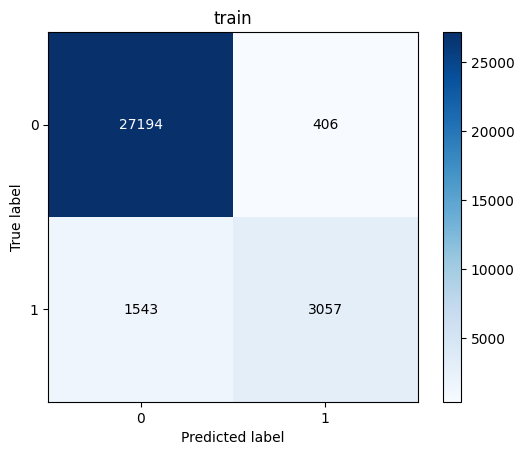

In [41]:
train_metrics = evaluate_model(
    train_true_label, train_pred_label, confusion_title="train"
)
print(
    f"recall: {train_metrics['recall']}, "
    + f"precision: {train_metrics['precision']}, "
    + f"specificity: {train_metrics['specificity']}"
)

In [42]:
fake_model_data = fake_data.loc[
    :, ["file_name", "transaction_id", "block_time"] + features + ["label", "no_alert"]
].fillna(0)


KeyError: "['no_alert'] not in index"

In [103]:
validation_model_data = validation_data.loc[
    :, ["file_name", "transaction_id", "block_time"] + features + ["label", "no_alert"]
].fillna(0)
clean_val_model_data = validation_model_data.loc[~validation_model_data["no_alert"], :]

In [104]:
validation_model_data["no_alert"].value_counts()

False    112737
True         18
Name: no_alert, dtype: int64

In [105]:
validation_model_data.shape

(112755, 58)

In [106]:
clean_val_model_data.shape

(112737, 58)

In [107]:
# dvalidation = xgb.DMatrix(validation_model_data.loc[:, selected], validation_model_data['label'])
# val_pred_prob = model.predict(dvalidatio)
# val_pred_label = (val_pred_prob > 0.5).astype(int)
# val_pred_label = model.predict(validation_model_data.loc[:, selected].fillna(0))
thr = 0.55
val_pred_prob = model.predict_proba(validation_model_data.loc[:, selected].fillna(0))
val_pred_label = (val_pred_prob[:, 1] > thr).astype(int)
# clean_val_pred_label = model.predict(clean_val_model_data.loc[:, selected].fillna(0))
clean_val_pred_prob = model.predict_proba(
    clean_val_model_data.loc[:, selected].fillna(0)
)
clean_val_pred_label = (clean_val_pred_prob[:, 1] > thr).astype(int)

In [108]:
# val_pred_label = model.predict(validation_model_data.loc[:, selected])
val_true_label = validation_model_data["label"]
clean_val_true_label = clean_val_model_data["label"]

recall: 0.773, precision: 0.203, specificity: 0.991


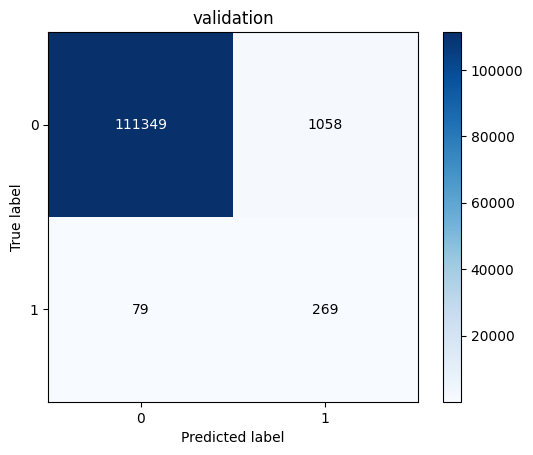

In [109]:
val_metrics = evaluate_model(
    val_true_label, val_pred_label, confusion_title="validation"
)
print(
    f"recall: {val_metrics['recall']}, "
    + f"precision: {val_metrics['precision']}, "
    + f"specificity: {val_metrics['specificity']}"
)

recall: 0.812, precision: 0.202, specificity: 0.991


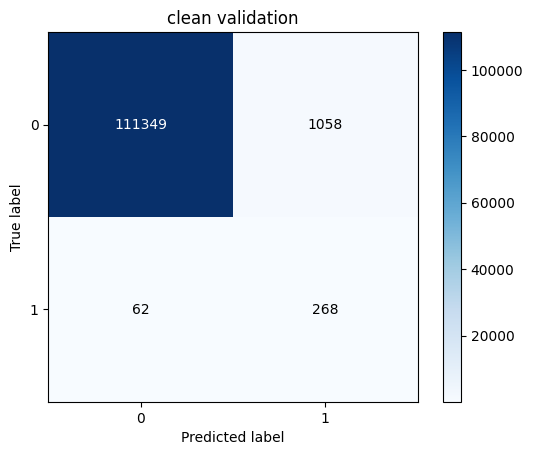

In [110]:
clean_val_metrics = evaluate_model(
    clean_val_true_label, clean_val_pred_label, confusion_title="clean validation"
)
print(
    f"recall: {clean_val_metrics['recall']}, "
    + f"precision: {clean_val_metrics['precision']}, "
    + f"specificity: {clean_val_metrics['specificity']}"
)

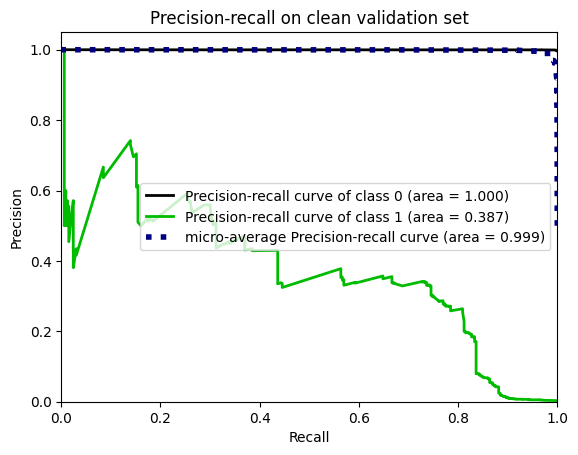

In [112]:
_ = skplt.metrics.plot_precision_recall(
    clean_val_true_label,
    clean_val_pred_prob,
    title="Precision-recall on clean validation set",
)

## 4 Report

In [113]:
if type(model) is LogisticRegression:
    model_coefs = (
        pd.DataFrame(zip(selected, model.coef_[0]), columns=["feature", "coef"])
        .sort_values("coef")
        .reset_index(drop=True)
    )
    print(model_coefs)

In [114]:
if type(model) in {RandomForestClassifier, GradientBoostingClassifier}:
    feature_importance = pd.DataFrame(
        zip(selected, model.feature_importances_), columns=["feature", "importance"]
    )
    print(feature_importance.sort_values("importance", ascending=False))

                                             feature  importance
1  snd_rcv_mean_amt_usd_tx_median_log_to_median_r...    0.497290
3   snd_rcv_life_time_sec_tx_min_log_to_median_ratio    0.237588
2              amount_usd_tx_sum_log_to_median_ratio    0.117414
6  snd_rcv_time_diff_sec_tx_mean_log_to_median_ratio    0.057934
5          snd_rcv_tx_cnt_tx_sum_log_to_median_ratio    0.037519
0    snd_rcv_amt_usd_sum_tx_mean_log_to_median_ratio    0.023169
4  snd_rcv_mean_time_diff_sec_tx_sum_log_to_media...    0.018831
7   snd_rcv_tkn_type_cnt_tx_mean_log_to_median_ratio    0.010255


In [115]:
train_pred_prob = model.predict_proba(train_data.loc[:, selected].fillna(0))[:, 1]
train_pred_label = (train_pred_prob > thr).astype(int)

In [116]:
train_results = train_data.loc[:, ["file_name", "label","sngl_mlt"]].copy()
train_results["pred_label"] = train_pred_label
train_results["exp_part"] = "train"

In [117]:
validation_results = validation_data.loc[:, ["file_name", "label", "sngl_mlt"]]
validation_results["pred_label"] = val_pred_label
validation_results["exp_part"] = "validation"

In [118]:
model_result = pd.concat([train_results, validation_results])

In [119]:
model_results = cases.merge(model_result)

In [120]:
model_results

,file_name,exploit_type,Minimum Date,train/test splits,label,sngl_mlt,pred_label,exp_part
0,V3/0xhabitat001.csv,Phishing,3/17/2021 12:11,Train,0,multi,0,train
1,V3/0xhabitat001.csv,Phishing,3/17/2021 12:11,Train,0,multi,0,train
2,V3/0xhabitat001.csv,Phishing,3/17/2021 12:11,Train,0,multi,0,train
3,V3/0xhabitat001.csv,Phishing,3/17/2021 12:11,Train,0,multi,0,train
4,V3/0xhabitat001.csv,Phishing,3/17/2021 12:11,Train,0,multi,0,train
...,...,...,...,...,...,...,...,...
763790,V3/Zenith006.csv,Rug pull,11/17/2017 15:20,Train,0,multi,0,train
763791,V3/Zenith006.csv,Rug pull,11/17/2017 15:20,Train,0,multi,0,train
763792,V3/Zenith006.csv,Rug pull,11/17/2017 15:20,Train,0,multi,0,train
763793,V3/Zenith006.csv,Rug pull,11/17/2017 15:20,Train,0,multi,0,train


In [121]:
#file_report, exploit_report = report_by_sections(model_results)
file_report, exploit_report, sng_mlt_report = report_by_sections(model_results)

In [122]:
file_report#exploit_report

,file_name,exp_part,exploit_type,sngl_mlt,tp,fp,tn,fn,catch_any
0,V3/0xhabitat001.csv,train,Phishing,multi,1,6,52,0,1
1,V3/Agora001.csv,train,Flash Loan Attack,single,0,12,12857,1,0
2,V3/Agora002.csv,train,Flash Loan Attack,multi,1,5,13048,1,1
3,V3/Akropolis001.csv,train,Flash Loan Attack,multi,0,1,487,17,0
4,V3/AnySwap001.csv,train,Access Control,single,1,367,17111,0,1
...,...,...,...,...,...,...,...,...,...
142,V3/Zenith004.csv,train,Rug pull,single,0,4,244,1,0
143,V3/Zenith005.csv,train,Rug pull,single,0,45,1644,1,0
144,V3/Zenith006.csv,train,Rug pull,multi,0,3,234,3,0
145,V3/bZx001.csv,validation,Access Control,multi,2,209,24715,0,1


In [123]:
exploit_report

,exploit_type,exp_part,files,catch_any,tp,fp,tn,fn,recall,precision
0,Access Control,train,50,0.800000,1073,9487,505149,240,0.817212,0.101610
1,Access Control,validation,15,0.466667,220,815,61237,25,0.897959,0.212560
2,Flash Loan Attack,train,18,0.888889,16,232,70335,19,0.457143,0.064516
3,Flash Loan Attack,validation,5,0.800000,47,225,35968,37,0.559524,0.172794
4,Phishing,train,16,0.187500,3,117,8328,29,0.093750,0.025000
5,Phishing,validation,5,0.000000,0,11,1230,5,0.000000,0.000000
6,Price Manupilation,train,5,1.000000,5,5,653,0,1.000000,0.500000
7,Price Manupilation,validation,1,0.000000,0,7,589,1,0.000000,0.000000
8,Re-Entrancy,train,2,0.500000,1,1,1105,6,0.142857,0.500000
9,Rug pull,train,23,0.521739,167,417,53508,144,0.536977,0.285959


In [124]:
sng_mlt_report

,sngl_mlt,exp_part,files,catch_any,tp,fp,tn,fn,recall,precision
0,multi,train,57,0.719298,1229,8905,476109,417,0.746659,0.121275
1,multi,validation,18,0.555556,266,1029,96778,67,0.798799,0.205405
2,single,train,57,0.631579,36,1354,162969,21,0.631579,0.025899
3,single,validation,15,0.200000,3,29,14571,12,0.200000,0.093750


In [125]:
file_report.groupby("exp_part")["catch_any"].mean()
#exploit_report.groupby("exp_part")["recall"].mean()

exp_part
train         0.675439
validation    0.393939
Name: catch_any, dtype: float64

In [126]:
file_report.loc[file_report["exploit_type"] != "Phishing", :].groupby("exp_part")[
    "catch_any"
].mean()

exp_part
train         0.755102
validation    0.464286
Name: catch_any, dtype: float64

In [127]:
train_data["pred_label"] = train_pred_label
validation_data["pred_label"] = val_pred_label

In [128]:
top_features = list(feature_importance.sort_values("importance")["feature"].tail(3))

In [129]:
top_features

['amount_usd_tx_sum_log_to_median_ratio',
 'snd_rcv_life_time_sec_tx_min_log_to_median_ratio',
 'snd_rcv_mean_amt_usd_tx_median_log_to_median_ratio']

In [130]:
#validation_data[validation_data['file_name'] == "V3/0xhabitat001.csv"]
#validation_data['file_name'].unique()

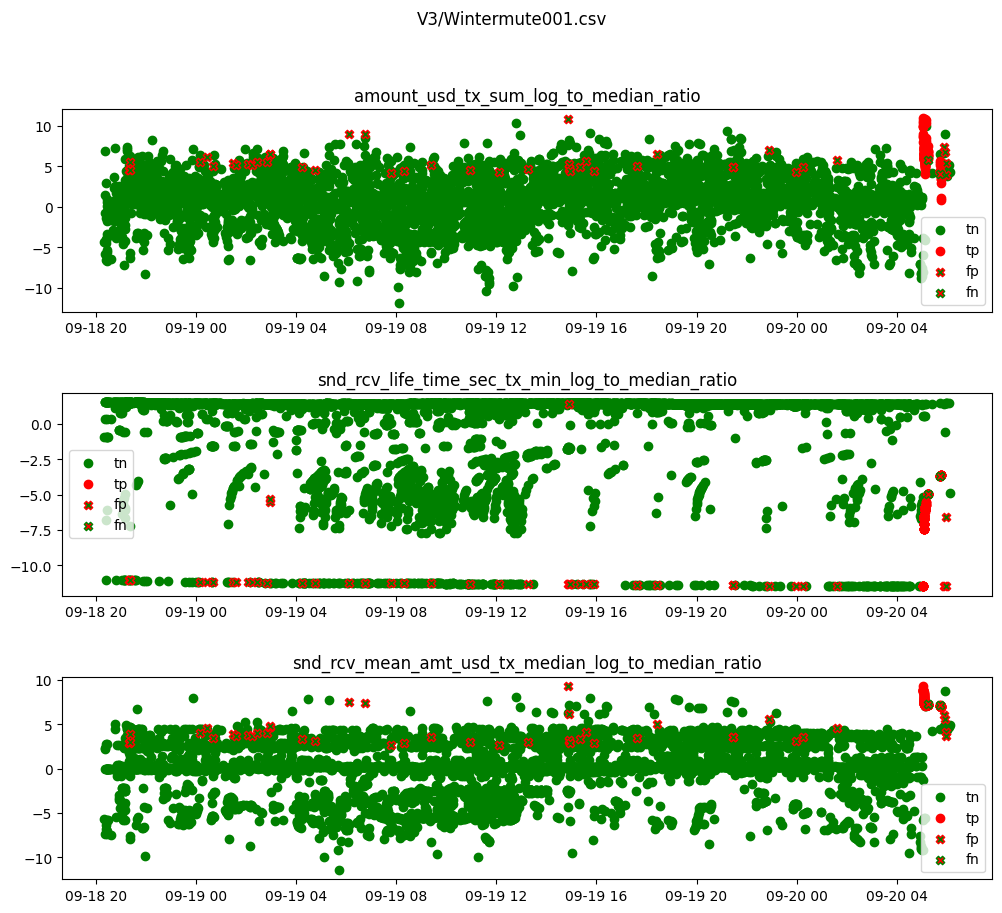

In [131]:
fig, axs = plot_case(validation_data, 'V3/Wintermute001.csv', top_features)#plot_case(validation_data, "V3/0xhabitat001.csv", top_features)

In [132]:
model_prefix = "resampled_no_phishing"
features_rep_table = feature_importance.merge(mu_score_df)

In [133]:
features_rep_table.to_csv("reports/" + model_prefix + "/feature_table.csv", index=False)

In [134]:
file_report.to_csv("reports/" + model_prefix + "/file_table.csv", index=False)

In [135]:
exploit_report.to_csv("reports/" + model_prefix + "/exploit_table.csv", index=False)

In [136]:
sng_mlt_report.to_csv("reports/" + model_prefix + "/single_multiple_table.csv", index=False)

In [68]:
with open('artifacts/' + model_prefix + '.pkl', 'wb') as f:
    pickle.dump(model, f)

In [69]:
from utils.s3 import MODELS_BUCKET
from utils import MODEL_NAME
bucket = boto3.resource('s3').Bucket(MODELS_BUCKET)
bucket.upload_file('artifacts/' + model_prefix + '.pkl', MODEL_NAME + '/artifacts/' + model_prefix + '.pkl')


In [70]:
os.getcwd()

'c:\\Users\\Anton\\Desktop\\s2\\attack-detection-v1'